In [1]:
import numpy as np 
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim 


In [2]:
x, y = make_circles(2000, noise=0.04, random_state=33)
x[:5],y[:5]

(array([[ 0.09836151, -1.0028988 ],
        [ 0.37675161,  0.89754454],
        [ 0.09264997, -0.82766605],
        [ 0.37515365, -0.76511622],
        [-0.8454029 , -0.59558418]]),
 array([0, 0, 1, 1, 0], dtype=int64))

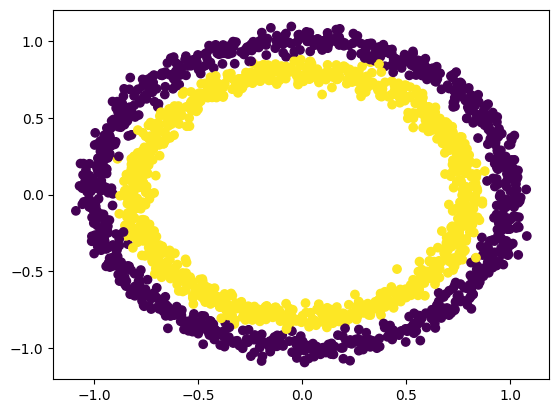

In [3]:
plt.scatter(x[:,0], x[:,1],c=y)

In [6]:
type(x), x.dtype

(numpy.ndarray, dtype('float64'))

In [8]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
type(x), x.dtype

(torch.Tensor, torch.float32)

In [12]:
type(y), y.dtype

(torch.Tensor, torch.float32)

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.3)

In [11]:
len(xtrain), len(xtest)

(1400, 600)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [65]:
class CircleClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.dense1 = nn.Linear(in_features=2, out_features=5)
        self.dense2 = nn.Linear(in_features=5, out_features=1)

    def forward(self,x):
        x = torch.relu(self.dense1(x))
        return torch.sigmoid(self.dense2(x))
    
model = CircleClassifier()
model = model.to(device)
model

CircleClassifier(
  (dense1): Linear(in_features=2, out_features=5, bias=True)
  (dense2): Linear(in_features=5, out_features=1, bias=True)
)

In [66]:
model.state_dict()

OrderedDict([('dense1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('dense1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('dense2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('dense2.bias', tensor([-0.2060], device='cuda:0'))])

In [67]:
loss_fn = nn.BCELoss() # requires sigmoid output and nn.BCEWithLogitsLoss doesn't requires that
optimizer = optim.SGD(params=model.parameters(),lr=0.2)

xtrain, ytrain = xtrain.to(device), ytrain.to(device)
xtest, ytest = xtest.to(device), ytest.to(device)

In [68]:
def cal_accuracy(ypred, ytrue):
    correct = (ypred == ytrue).sum().item()
    acc = (correct/len(ypred))*100
    return acc

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

for i in range(0,epochs+1):
    model.train()

    y_pred = model(xtrain).squeeze()
    loss = loss_fn(y_pred,ytrain)
    
    y_pred = torch.round(y_pred)
    
    acc = cal_accuracy(y_pred,ytrain)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%100==0:
        print(f"Epochs {i+1} , Loss: {loss.item():.5f}, Accuracy: {acc:.5f}")
    

Epochs 1 , Loss: 0.69754, Accuracy: 50.14286
Epochs 101 , Loss: 0.69037, Accuracy: 51.85714
Epochs 201 , Loss: 0.68495, Accuracy: 55.50000
Epochs 301 , Loss: 0.67841, Accuracy: 57.21429
Epochs 401 , Loss: 0.66953, Accuracy: 58.71429
Epochs 501 , Loss: 0.65558, Accuracy: 60.78571
Epochs 601 , Loss: 0.63323, Accuracy: 69.50000
Epochs 701 , Loss: 0.60042, Accuracy: 88.57143
Epochs 801 , Loss: 0.55924, Accuracy: 91.42857
Epochs 901 , Loss: 0.51072, Accuracy: 93.21429
Epochs 1001 , Loss: 0.45695, Accuracy: 94.64286


In [70]:
with torch.inference_mode():
    prediction = model(xtest).squeeze()
    loss = loss_fn(prediction, ytest)

    prediction = torch.round(prediction)
    acc = cal_accuracy(prediction,ytest)
    print(f"Loss: {loss.item():.5f}  Accuracy: {acc:.5f}")

Loss: 0.46064  Accuracy: 94.33333
